In [96]:
## Select desired libraries
import tensorflow as tf
from sklearn.model_selection import RepeatedKFold
import earthdata as ed
import numpy as np

In [97]:
# Define model
def get_model(n_inputs, n_outputs):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(20, input_dim=n_inputs, activation='relu'))
    model.add(tf.keras.layers.Dense(50, kernel_initializer='he_uniform', activation='exponential'))
    model.add(tf.keras.layers.Dense(50, activation='relu'))
    model.add(tf.keras.layers.Dense(50, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(n_outputs))
    model.compile(loss = 'mae' , optimizer='adam')
    #print(model.summary())
    return model

In [98]:
# Constant definitions
DATASET_NAME = 'MODIS/006/MOD44W'  # Name of dataset to extract water bodies information
STARTING_DATE = '2000-01-01'  # First element of the dataset
ENDING_DATE = '2015-05-01'  # Last element of the dataset
BAND = 'water_mask'  # Dataset band we are interested in

# User parameters
lat, lon = 20.24, -103.06  # Center coordinates
dx = 0.8  # Rectangle length
dy = 0.3  # Rectangle width

data_proxy = ed.EarthData()
data_proxy.select_dataset(DATASET_NAME, STARTING_DATE, ENDING_DATE, BAND)
X, y, rows, columns = data_proxy.get_dataset(lat, lon, dx, dy)
X_t = tf.constant(X)
X_t = X_t-2000
y_t = tf.constant(y)

2022-06-24 18:00:34.258707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1.0186784
-0.020699382


2022-06-24 18:00:39.023094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


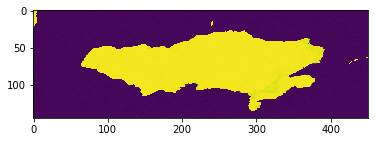

In [99]:
n_inputs, n_outputs = X_t.shape[1], y_t.shape[1]
# get model
model = get_model(n_inputs, n_outputs)
# fit the model on all data
model.fit(X_t, y_t, verbose=0, epochs=200)
newX = tf.constant([2005-2000])
y_predicted = model.predict(newX)

ed.plot_map(y_predicted.flatten(), rows, columns)
print(y_predicted.max())
print(y_predicted.min())

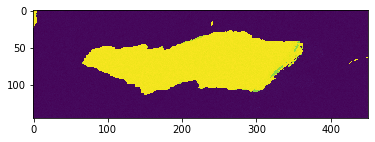

In [100]:
newX = tf.constant([2000-2000])
y_predicted = model.predict(newX)
ed.plot_map(y_predicted.flatten(), rows, columns)

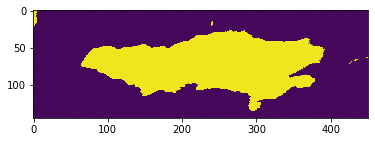

In [101]:
# plot predicted map
newX = tf.constant([2015-2000])
y_predicted = model.predict(newX)
ed.plot_map(y_predicted.flatten(), rows, columns)

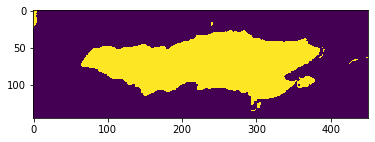

In [85]:
# plot original map
ed.plot_map(y[2015-2000].flatten(), rows, columns)

In [7]:
# Evaluate model to test accuracy in different scenarios

# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
    results = list()
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    # define evaluation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # enumerate folds
    for train_ix, test_ix in cv.split(X):
        # prepare data
        X_train, X_test = tf.constant(X[train_ix]), tf.constant(X[test_ix])
        y_train, y_test = tf.constant(y[train_ix]), tf.constant(y[test_ix])
        # define model
        model = get_model(n_inputs, n_outputs)
        # fit model
        model.fit(X_train, y_train, verbose=0, epochs=50)
        # evaluate model on test set
        mae = model.evaluate(X_test, y_test, verbose=0)
        # store result
        print('>%.3f' % mae)
        results.append(mae)
    return results

In [102]:
rect_1 = np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]
                  )

In [103]:
rect_2 = np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0],
                   [0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0],
                   [0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0],
                   [0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]
                  )

In [104]:
rect_3 = np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0],
                   [0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0],
                   [0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0],
                   [0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0],
                   [0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0],
                   [0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]
                  )

In [105]:
rect_4 = np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0],
                   [0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0],
                   [0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0],
                   [0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0],
                   [0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0],
                   [0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0],
                   [0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0],
                   [0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]
                  )

In [106]:
y_rect = tf.constant([rect_1.flatten(), rect_2.flatten(), rect_3.flatten(), rect_4.flatten()])
X_rect = [[1],[2],[3],[4]]
y = tf.constant(y_rect)
X = tf.constant(X_rect)

2022-06-24 18:01:26.502710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-24 18:01:38.068954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


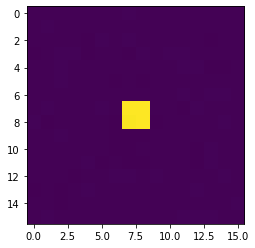

In [107]:
n_inputs, n_outputs = X.shape[1], y.shape[1]
# get model
model = get_model(n_inputs, n_outputs)
# fit the model on all data
model.fit(X, y, verbose=0, epochs=2000)
newX = tf.constant([1])
y_predicted = model.predict(newX)
ed.plot_map(y_predicted.flatten(), 16, 16)

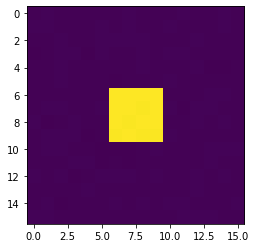

In [108]:
newX = tf.constant([2])
y_predicted = model.predict(newX)
ed.plot_map(y_predicted.flatten(), 16, 16)

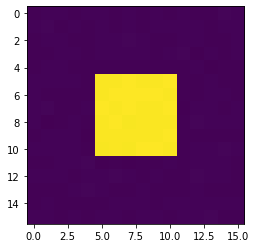

In [109]:
newX = tf.constant([3])
y_predicted = model.predict(newX)
ed.plot_map(y_predicted.flatten(), 16, 16)